<a href="https://colab.research.google.com/github/0o0liver/Going_Back_to_Work/blob/master/Demand_Model_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import glob, os 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import metrics
from datetime import datetime, timedelta
from functools import partial
from IPython.core.debugger import set_trace
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!wget -q https://raw.githubusercontent.com/0o0liver/Going_Back_to_Work/master/datasets/resultant_data/dropoff_200_west_street_nyc_2010.csv
!wget -q https://raw.githubusercontent.com/0o0liver/Going_Back_to_Work/master/datasets/resultant_data/dropoff_200_west_street_nyc_2011.csv
!wget -q https://raw.githubusercontent.com/0o0liver/Going_Back_to_Work/master/datasets/resultant_data/dropoff_200_west_street_nyc_2012.csv
!wget -q https://raw.githubusercontent.com/0o0liver/Going_Back_to_Work/master/datasets/resultant_data/dropoff_200_west_street_nyc_2013.csv

In [0]:
all_files = glob.glob(os.path.join('/content', "*.csv"))
df = pd.concat((pd.read_csv(f, parse_dates=[0], index_col=0, usecols=[0], date_parser=pd.to_datetime) for f in all_files))

In [0]:
df_copy = df.copy()
df_copy['count'] = 4.
df_copy = df_copy.resample("30min").sum()
df_copy = df_copy.loc[:'2013-05-01'] # filter out last days of december 

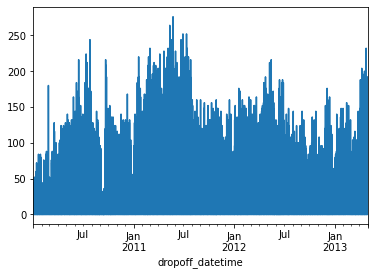

In [5]:
df_copy['count'].plot()

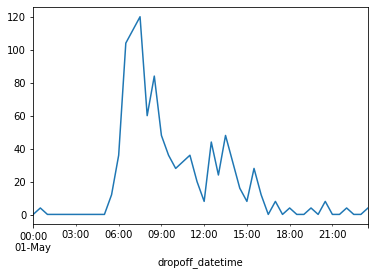

In [6]:
s = df_copy['count']
X = s.where(s > 0, 0.1) # cannot have 0 values for holt-winters
size = int(len(X)-48) # 2 periods per hour, 24 hours per day = 48 periods per day
train, test = X[0:size], X[size:len(X)]
test.plot()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Test MSE: 250.700


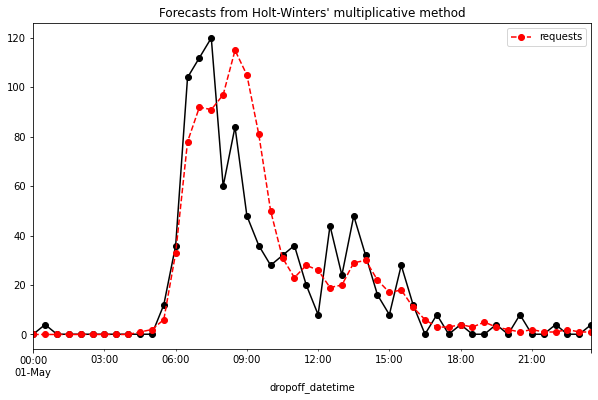

Figure 1


In [7]:
fit1 = sm.tsa.ExponentialSmoothing(train, seasonal_periods=336, trend='add', seasonal='add').fit(use_boxcox=True)

results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]

ax = test.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' multiplicative method" )

yhat = fit1.forecast(len(X)-size).rename('requests').round()

error = metrics.mean_squared_error(test.values.ravel(), yhat.values.ravel())
print('Test MSE: %.3f' % error)

yhat.plot(ax=ax, style='--', marker='o', color='red', legend=True)

plt.show()
print("Figure 1")